# Relax Challenge

Please send us a brief writeup of your findings (the more concise, the better­­ no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

***Engagement:*** has a row for each day that a user logged into the product.

***Users:***
- **name:** the user's name
- **object_id:** the user's id
- **email:** email address
- **creation_source:** how their account was created. This takes on one of 5 values:
    - **PERSONAL_PROJECTS:** invited to join another user's personal workspace
    - **GUEST_INVITE:** invited to an organization as a guest (limited permissions)
    - **ORG_INVITE:** invited to an organization (as a full member)
    - **SIGNUP:** signed up via the website
    - **SIGNUP_GOOGLE_AUTH:** signed up using Google Authentication (using a Google email account for their login id)
- **creation_time:** when they created their account
- **last_session_creation_time:** unix timestamp of last login
- **opted_in_to_mailing_list:** whether they have opted into receiving marketing emails
- **enabled_for_marketing_drip:** whether they are on the regular marketing email drip
- **org_id:** the organization (group of users) they belong to
- **invited_by_user_id:** which user invited them to join (if applicable).

### Initial Inspection and Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


In [2]:
engagement_df = pd.read_csv('takehome_user_engagement.csv')
users_df = pd.read_csv('takehome_users.csv', encoding='latin-1')

print('Engagement shape: ', engagement_df.shape)
print('Users shape: ', users_df.shape)

Engagement shape:  (207917, 3)
Users shape:  (12000, 10)


In [3]:
print(engagement_df.info(), '\n') 
print(users_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   e

In [4]:
users_df.describe().applymap(lambda x: f"{x:0.2f}").T

/var/folders/32/0gd9yf194_vbqz8wsbsl0ltw0000gn/T/ipykernel_20034/3768463419.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  users_df.describe().applymap(lambda x: f"{x:0.2f}").T


,count,mean,std,min,25%,50%,75%,max
object_id,12000.00,6000.50,3464.25,1.00,3000.75,6000.50,9000.25,12000.00
last_session_creation_time,8823.00,1379279305.70,19531160.79,1338452406.00,1363194965.00,1382888470.00,1398442604.00,1402066730.00
opted_in_to_mailing_list,12000.00,0.25,0.43,0.00,0.00,0.00,0.00,1.00
enabled_for_marketing_drip,12000.00,0.15,0.36,0.00,0.00,0.00,0.00,1.00
org_id,12000.00,141.88,124.06,0.00,29.00,108.00,238.25,416.00
invited_by_user_id,6417.00,5962.96,3383.76,3.00,3058.00,5954.00,8817.00,11999.00


In [5]:
# convert dates to datetime
users_df.creation_time = users_df.creation_time.astype('datetime64[ns]')
users_df.last_session_creation_time = users_df.last_session_creation_time.astype('datetime64[ns]')
engagement_df.time_stamp = engagement_df.time_stamp.astype('datetime64[ns]')

users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240.0


### Identify Adopted Users

An **adopted user** is defined as a user who has logged into the product on three separate days in at least one seven­day period

In [6]:
# sort by user_is and time_stamp    
engagement_df = engagement_df.sort_values(by=['user_id', 'time_stamp'])
# group by user_id and count the number of visits within a 7 day period
grouped_id = engagement_df.groupby('user_id').rolling('7D', on='time_stamp').sum()

grouped_id.loc[1:2]


time_stamp  visited
user_id                                
1       0  2014-04-22 03:53:30      1.0
2       1  2013-11-15 03:45:04      1.0
        2  2013-11-29 03:45:04      1.0
        3  2013-12-09 03:45:04      1.0
        4  2013-12-25 03:45:04      1.0
        5  2013-12-31 03:45:04      2.0
        6  2014-01-08 03:45:04      1.0
        7  2014-02-03 03:45:04      1.0
        8  2014-02-08 03:45:04      2.0
        9  2014-02-09 03:45:04      3.0
        10 2014-02-13 03:45:04      3.0
        11 2014-02-16 03:45:04      2.0
        12 2014-03-09 03:45:04      1.0
        13 2014-03-13 03:45:04      2.0
        14 2014-03-31 03:45:04      1.0

In [7]:
# Identify user_ids where visited is greater than or equal to 3
adopted_user_ids = grouped_id[grouped_id['visited'] >= 3].index.get_level_values('user_id').unique()

print('Number of adopted users: ', len(adopted_user_ids))

Number of adopted users:  1602


In [8]:
# add column to indicate whether a user is adopted or not
users_df['adopted'] = users_df['object_id'].apply(lambda x: 1 if x in adopted_user_ids else 0)
print(users_df['adopted'].sum())
users_df.head()

1602


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240.0,0


### Feature Engineering

num_login = total number of logins recorded

duration = days between creation and last login


In [9]:
# Merge users_df with the maximum time_stamp from engagement_df
max_time_stamp = engagement_df.groupby('user_id')['time_stamp'].max().reset_index()
max_time_stamp.columns = ['object_id', 'max_time_stamp']

# Merge with users_df
users_df = users_df.merge(max_time_stamp, on='object_id', how='left')

# Calculate the duration in days
users_df['duration'] = (users_df['max_time_stamp'] - users_df['creation_time']).dt.days

# Drop the max_time_stamp column as it's no longer needed
users_df = users_df.drop(columns=['max_time_stamp'])

In [10]:
# Count the number of logins for each user_id in engagement_df
login_counts = engagement_df['user_id'].value_counts()

# Map the login counts to the users_df
users_df['num_logins'] = users_df['object_id'].map(login_counts).fillna(0).astype(int)

users_df['login_rate'] = users_df['num_logins'] / users_df['duration']

users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted                     12000 non-null  int64         
 11  duration                    8823 non-null   float64   

### Preparing for Models

In [11]:
clean_df = users_df.drop(['creation_time', 'name', 'email', 'last_session_creation_time', 'object_id', 'invited_by_user_id', 'num_logins'], axis=1)
clean_df = pd.get_dummies(clean_df, columns=['creation_source'])
clean_df = clean_df.fillna(0)
clean_df.replace([np.inf, -np.inf], 0, inplace=True)

for col in clean_df.select_dtypes(include='bool').columns.tolist():
    clean_df[col] = clean_df[col].astype('int64')

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   opted_in_to_mailing_list            12000 non-null  int64  
 1   enabled_for_marketing_drip          12000 non-null  int64  
 2   org_id                              12000 non-null  int64  
 3   adopted                             12000 non-null  int64  
 4   duration                            12000 non-null  float64
 5   login_rate                          12000 non-null  float64
 6   creation_source_GUEST_INVITE        12000 non-null  int64  
 7   creation_source_ORG_INVITE          12000 non-null  int64  
 8   creation_source_PERSONAL_PROJECTS   12000 non-null  int64  
 9   creation_source_SIGNUP              12000 non-null  int64  
 10  creation_source_SIGNUP_GOOGLE_AUTH  12000 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 1.0

In [12]:
X = clean_df.drop('adopted', axis=1)
y = clean_df['adopted']

print(X.shape)
print(y.shape)
y.value_counts()

(12000, 10)
(12000,)


adopted
0    10398
1     1602
Name: count, dtype: int64

### Modeling 

In [13]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# model selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score



In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=55)

scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_sc, y, test_size=0.4, random_state=55)

In [15]:
def overfit_check(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    model.fit(X_train, y_train)

    # Evaluate on training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)

    # Evaluate on test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    print('\n', model)
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Training F1 Score: {train_f1:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")


In [16]:
# Logistic Regression
lr = LogisticRegression()

# cross validation
cv_scores = cross_val_score(lr, X_train_sc, y_train, cv=5)
print(f"Average CV Score: {np.mean(cv_scores):.4f}")

lr.fit(X_train_sc, y_train)
y_pred = lr.predict(X_test_sc)

print('Accuracy: ', accuracy_score(y_test, y_pred)) 
print('F1 Score: ', f1_score(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

overfit_check(lr, X_train_sc, X_test_sc, y_train_sc, y_test_sc)

Average CV Score: 0.9746
Accuracy:  0.9727083333333333
F1 Score:  0.8967691095350669
Confusion Matrix: 
 [[4100   27]
 [ 104  569]]

 LogisticRegression()
Training Accuracy: 0.9757
Training F1 Score: 0.9011
Test Accuracy: 0.9727
Test F1 Score: 0.8968


In [17]:
knn = KNeighborsClassifier(n_neighbors=5)

# cross validation
cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
print(f"Average CV Score: {np.mean(cv_scores):.4f}")

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred)) 
print('F1 Score: ', f1_score(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

overfit_check(knn)

Average CV Score: 0.9728
Accuracy:  0.9697916666666667
F1 Score:  0.890895410082769
Confusion Matrix: 
 [[4063   64]
 [  81  592]]

 KNeighborsClassifier()
Training Accuracy: 0.9801
Training F1 Score: 0.9224
Test Accuracy: 0.9698
Test F1 Score: 0.8909


In [18]:
svc = SVC()

# cross validation
cv_scores = cross_val_score(svc, X_train, y_train, cv=5)
print(f"Average CV Score: {np.mean(cv_scores):.4f}")

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred)) 
print('F1 Score: ', f1_score(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

overfit_check(svc)

Average CV Score: 0.9747
Accuracy:  0.971875
F1 Score:  0.8937844217151849
Confusion Matrix: 
 [[4097   30]
 [ 105  568]]

 SVC()
Training Accuracy: 0.9753
Training F1 Score: 0.8993
Test Accuracy: 0.9719
Test F1 Score: 0.8938


In [19]:
dt = DecisionTreeClassifier()

# cross validation
cv_scores = cross_val_score(dt, X_train, y_train, cv=3)
print(f"Average CV Score: {np.mean(cv_scores):.4f}")

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred)) 
print('F1 Score: ', f1_score(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

overfit_check(dt)   

Average CV Score: 0.9843
Accuracy:  0.9852083333333334
F1 Score:  0.9467366841710427
Confusion Matrix: 
 [[4098   29]
 [  42  631]]

 DecisionTreeClassifier()
Training Accuracy: 1.0000
Training F1 Score: 1.0000
Test Accuracy: 0.9854
Test F1 Score: 0.9476


In [20]:
rf = RandomForestClassifier()

# cross validation
cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
print(f"Average CV Score: {np.mean(cv_scores):.4f}")

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred)) 
print('F1 Score: ', f1_score(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

overfit_check(rf)

Average CV Score: 0.9860
Accuracy:  0.9835416666666666
F1 Score:  0.939183987682833
Confusion Matrix: 
 [[4111   16]
 [  63  610]]

 RandomForestClassifier()
Training Accuracy: 1.0000
Training F1 Score: 1.0000
Test Accuracy: 0.9817
Test F1 Score: 0.9320


### Feature Importance

In [22]:
# Extract the coefficients from the logistic regression model
coefficients = lr.coef_[0]

# Create a DataFrame to display the feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    })
# Sort the DataFrame by the absolute value of the coefficients
feature_importance_df = feature_importance_df.reindex(feature_importance_df.Coefficient.abs().sort_values(ascending=False).index)

print(feature_importance_df.head(5))

                              Feature  Coefficient
3                            duration     7.402740
4                          login_rate     0.263921
2                              org_id     0.176010
7   creation_source_PERSONAL_PROJECTS    -0.162573
9  creation_source_SIGNUP_GOOGLE_AUTH     0.099680


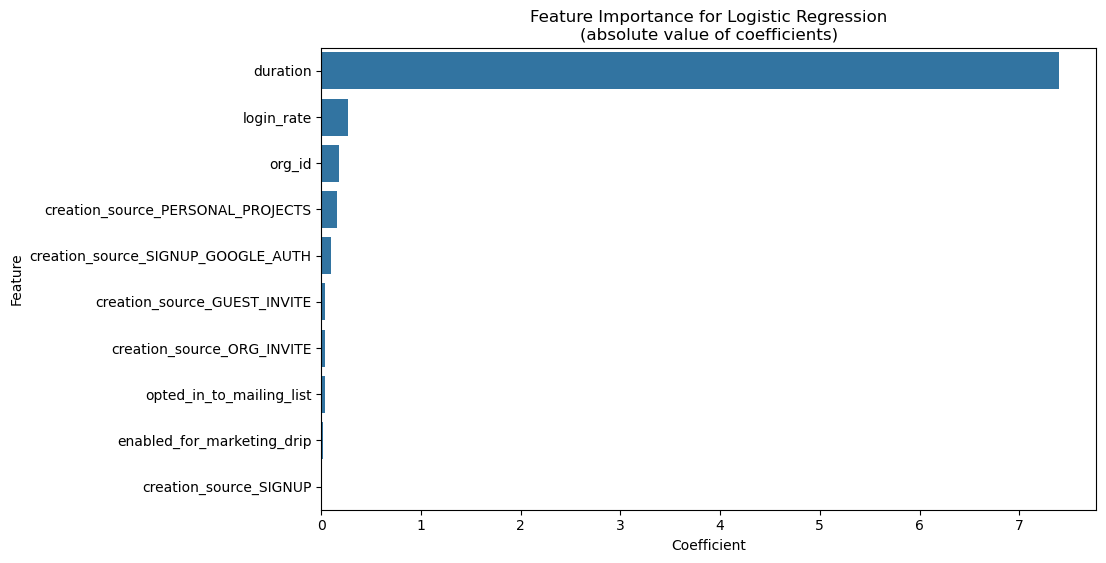

In [23]:
feature_importance_lr_df['abs_coefficient'] = feature_importance_lr_df['Coefficient'].abs()

# Plotting the feature importance for logistic regression
plt.figure(figsize=(10, 6))
sns.barplot(x='abs_coefficient', y='Feature', data=feature_importance_lr_df)
plt.title('Feature Importance for Logistic Regression\n(absolute value of coefficients)')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()
#plt.savefig('feature_importance_lr.png')